In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.distributions import Normal
from scipy.stats import norm
import sdeint
from src.RC import *

%load_ext autoreload
%autoreload 2

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
    # random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
setup_seed(23)

**data**

$dX_t = X_t - X_t^3dt + 1 dB_t$ 


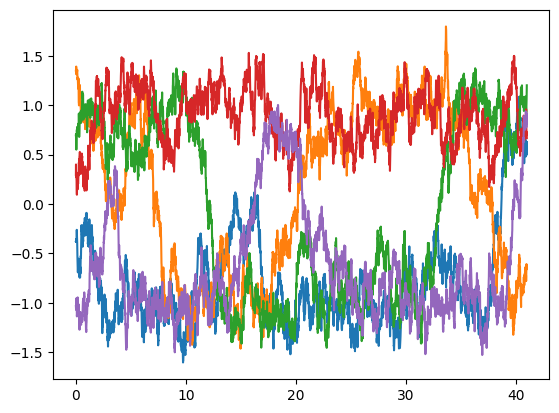

In [3]:
#generate data 
# load the data
trainLen = 2000
errorLen = 100
testLen = 2000
initLen = 100
minLen = min(trainLen-initLen, testLen)

# generate the ESN reservoir
inSize = outSize = 1
resSize = 500

np.random.seed(42)

trajectory_N = 2000#number of trajectories
trajectory_len = trainLen + errorLen +testLen #length of each trajectory
trajectory_all = np.zeros((trajectory_N, trajectory_len))

x0 =  np.random.uniform(-1.5,1.5,trajectory_N)
dt = 0.01

from scipy.integrate import odeint


def f(x, t):
    return x - x**3#0.15 * (1.0 - x) 

def g(x, t):
    return .5+ 0 * x
t = np.arange(0, trajectory_len) * dt 

for i in range(trajectory_N):
    result = sdeint.itoEuler(f, g, x0[i], t.reshape(-1,), generator = np.random.default_rng(i))
    trajectory_all[i] = result.reshape(-1,)
plt.plot(t, trajectory_all.T[:,:5]) 
# trajectory_all[0] = result.reshape(-1,)
# plt.xlim([-0.1,2.5])
t = t.reshape(-1,1)

Text(0.5, 0, 'PDF')

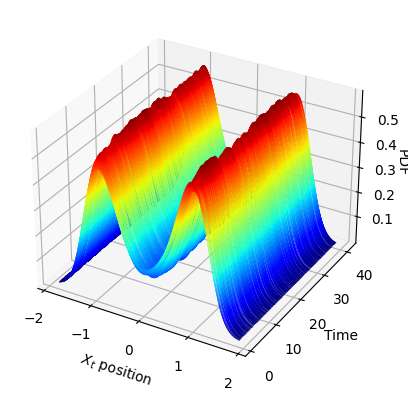

In [6]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
datamin = np.min(trajectory_all)
datamax = np.max(trajectory_all)
x_axis = np.linspace(datamin, datamax, 200)
y_axis = np.arange(initLen,trajectory_len)*dt
X_axis, Y_axis = np.meshgrid(x_axis, y_axis)
data_Z = np.zeros((200, trajectory_len-initLen))
for i in range(0,trajectory_len-initLen):
    kde_data = sp.stats.gaussian_kde(trajectory_all[:, initLen+i])
    data_Z[:,i] = kde_data(x_axis).reshape(-1,)
    
ax.plot_surface(X_axis,Y_axis, data_Z.T, rstride=1,cstride=1,cmap=plt.cm.jet) 
ax.set_xlabel('$X_t$ position')
ax.set_ylabel('Time')
ax.set_zlabel('PDF', rotation =270, labelpad=-2.)

# fig.savefig('./image/DW/DW3Dpdf.jpg',dpi=500,format='jpg')


**RC**

In [7]:

seed = 42


**sinkhorn distance and error**

In [8]:
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        mu = torch.empty(batch_size, x_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / x_points).squeeze()
        nu = torch.empty(batch_size, y_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / y_points).squeeze()

        u = torch.zeros_like(mu)
        v = torch.zeros_like(nu)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

        return cost, pi, C

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=2):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

**BO**

In [12]:
# #L2error
# import time
# T1 = time.perf_counter()

# # scikit optimize
# from skopt import gp_minimize
# from skopt.space import Real, Integer
# from skopt.utils import use_named_args

# space  = [Integer(1, 5, name='w_res_degree'),
#           Real(0.3, 1.5, "uniform", name='win_a'),
#           Real(0.05, 1., "uniform", name='alpha'),
#           Real(0.3, 1.5, "uniform", name='eig_rho'),
#           Real(1e-10, 1e+0, "log-uniform", name='reg')
#          ]
# default_parameters = [4, 1., 0.3, 1.25, 1e-8]

# @use_named_args(space)

# def optimization_l2(alpha, eig_rho, w_res_degree, win_a, reg):
#     print('*******************')
#     print('win_a: %.4f'%(win_a))
#     print('w_degree:', w_res_degree)
#     print('alpha rate: %.6f'%(alpha))
#     print('eig_rho: %.6f'%(eig_rho))
#     print('res: %.6f'%(reg))
    
#     Win = W_in(resSize, inSize, win_a, seed)
#     W = W_res(w_res_degree, resSize, eig_rho)

#     ESN_par = [resSize, alpha, reg, trainLen, initLen, inSize, trajectory_N]

#     Wout, last_res = create_ESN(ESN_par, trajectory_all, Win, W)
    
# #     errorLen = 1999
#     error_val,last_res_val = error_cal(trajectory_all, trajectory_N, last_res, outSize, inSize, trainLen, errorLen, Wout, W, Win, alpha)
#     return error_val

# op_gp_l2 = gp_minimize(optimization_l2, space, n_calls=50, random_state=10, x0 = default_parameters)

# T2 =time.perf_counter()
# print('Program run time:%s seconds' % ((T2 - T1)))

In [13]:

# print("""Best score=%.4f
# Best parameters:
# - degree=%d
# - win_rho=%.6f
# - leak rate=%.6f
# - w_res_eig_rho=%.6f
# - res_para=%.10f""" % (op_gp_l2.fun, op_gp_l2.x[0], op_gp_l2.x[1], 
#                             op_gp_l2.x[2], op_gp_l2.x[3], 
#                             op_gp_l2.x[4]))
# print(np.array([op_gp_l2.x[0], op_gp_l2.x[1], op_gp_l2.x[2], op_gp_l2.x[3], op_gp_l2.x[4]]))
# # hy = np.array([op_gp.x[0], op_gp.x[1], op_gp.x[2], op_gp.x[3], op_gp.x[4]])
# # np.save('hyper.npy',hy)
# from skopt.plots import plot_convergence

# plot_convergence(op_gp_l2)

In [14]:
# from skopt.plots import plot_objective, plot_evaluations
# _ = plot_objective(op_gp_l2, n_points=40)
# plot_evaluations(op_gp_l2)

In [15]:
#Store hyperparameters

# hy = np.array([op_gp_l2.x[0], op_gp_l2.x[1], op_gp_l2.x[2], op_gp_l2.x[3], op_gp_l2.x[4]])
# np.save('./data/dw2.npy',hy)

**Prediction**

In [16]:
# hy = np.load('hyper.npy')
# #hyper
# w_degree = 4
# win_a = 1
# a = 0.3  # leaking rate
# eig_rho = 1.25
# reg = 1e-8  # regularization coefficient

# #hyper
# w_degree = op_gp_l2.x[0]
# win_a = op_gp_l2.x[1]
# a = op_gp_l2.x[2]  # leaking rate
# eig_rho = op_gp_l2.x[3]
# reg = op_gp_l2.x[4]  # regularization coefficient

hy = np.load('./data/dw2.npy')
#hyper
w_degree = hy[0]
win_a = hy[1]
a = hy[2]  # leaking rate
eig_rho = hy[3]
reg = hy[4]  # regularization coefficientt
            .        

Computing spectral radius...4.3214715406939295 done.
Reservoir states shape: (502, 3800000)
Train data flatten shape:(1, 3800000)
Last reservoir shape: (500, 2000)
**Reservoir states collection finished**
MSE in training = 0.0024995529601971726
MSE = 0.002518609583328217


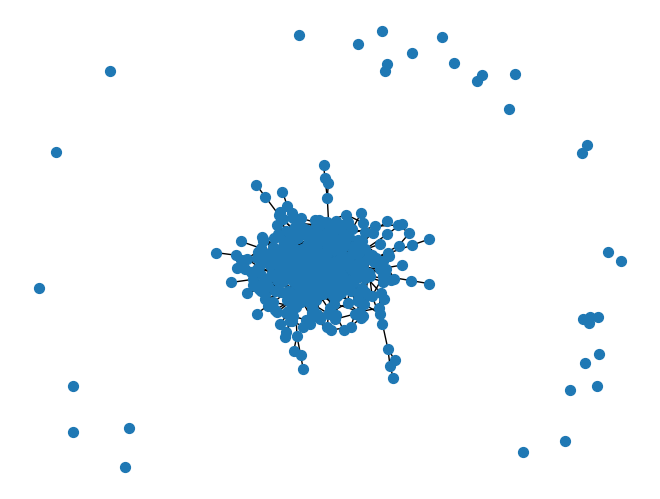

In [17]:
Win = W_in(resSize, inSize, win_a, seed)
W = W_res(w_degree, resSize,eig_rho)

ESN_par = [resSize, a, reg, trainLen, initLen, inSize, trajectory_N]

Wout, last_res = create_ESN(ESN_par, trajectory_all, Win, W)

error,last_res_for_test = error_cal(trajectory_all, trajectory_N, last_res, outSize, inSize, trainLen, errorLen, Wout, W, Win, a)

**RC prediction**

In [18]:


y_pred = prediction(trajectory_all, trajectory_N, last_res_for_test, outSize, inSize, trainLen+errorLen, testLen, Wout, W, Win, a)



**error modelling**

(generate error samples)

In [23]:
#non-rolling error boxplot
y_train_nr = errortrain_NR(ESN_par, trajectory_all, Win, W, Wout)
y_train_nr_reshape = y_train_nr.reshape(trajectory_N, -1)

error_train_nr = y_train_nr_reshape - trajectory_all[:, initLen +1: trainLen +1]
error_train_nr.shape

Reservoir states shape: (502, 3800000)

**Reservoir states collection finished**


(2000, 1900)

**NF**

In [30]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser


from src.flows import *
from src.models import NormalizingFlowModel, TemporalNormalizingFlowModel


def plot_data(x, bandwidth = 0.2, **kwargs):
    kde = sp.stats.gaussian_kde(x[:,0])
    x_axis = np.linspace(-1, 1, 200)
    plt.plot(x_axis, kde(x_axis), **kwargs)
#     plt.axis("off")
# torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())
# torch.cuda.set_device(0)

In [31]:
import time
#non-rolling nf

T3 =time.perf_counter()
try: 
    torch.set_default_tensor_type('torch.FloatTensor')
except:
    pass

argparser = ArgumentParser()
argparser.add_argument("--n", default=512, type=int)
argparser.add_argument("--flows", default=2, type=int)
argparser.add_argument("--flow", default="NSF_AR", type=str)
argparser.add_argument("--iterations", default=500, type=int)
args = argparser.parse_args(args=[])

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

flow = eval(args.flow)
flows = [flow(dim=1) for _ in range(args.flows)]
model_nr = NormalizingFlowModel(dim=1, flows=flows)

optimizer = optim.Adam(model_nr.parameters(), lr=0.005)
x_ = torch.Tensor(error_train_nr.reshape(-1,1))
x = torch.zeros_like(x_)

for i in range(x.shape[1]):
    x[:,i] = (x_[:,i] - torch.mean(x_[:,i])) / torch.std(x_[:,i])

for i in range(args.iterations):
    optimizer.zero_grad()
    z, prior_logprob, log_det = model_nr(x)
    logprob = prior_logprob + log_det
    loss = -torch.mean(prior_logprob + log_det)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Iter: {i}\t" +
                    f"Logprob: {logprob.mean().data:.2f}\t" +
                    f"Prior: {prior_logprob.mean().data:.2f}\t" +
                    f"LogDet: {log_det.mean().data:.2f}")

T4 =time.perf_counter()
print('Program running time:%s seconds' % ((T4 - T3)))

Iter: 0	Logprob: -2.56	Prior: -2.64	LogDet: 0.08
Iter: 100	Logprob: -1.42	Prior: -1.43	LogDet: 0.01
Iter: 200	Logprob: -1.42	Prior: -1.42	LogDet: 0.00
Iter: 300	Logprob: -1.42	Prior: -1.42	LogDet: 0.00
Iter: 400	Logprob: -1.42	Prior: -1.42	LogDet: 0.00
程序运行时间:589.190499217秒


standardization $x = (x_{init} - x_{mean})/x_{std}$

<!-- k=5,b=3
#error time interval 100
![image.png](attachment:image.png)
#error time interval 100-199
![image-2.png](attachment:image-2.png)
#error time interval 100-1099
![image-3.png](attachment:image-3.png)
#error time interval 100-1999
![image-4.png](attachment:image-4.png) -->

In [33]:
error_samples_nr_ = model_nr.sample(trajectory_N * testLen *inSize).data.numpy()
error_samples_nr = error_samples_nr_ * torch.std(x_[:,0]).numpy() + torch.mean(x_[:,0]).numpy()

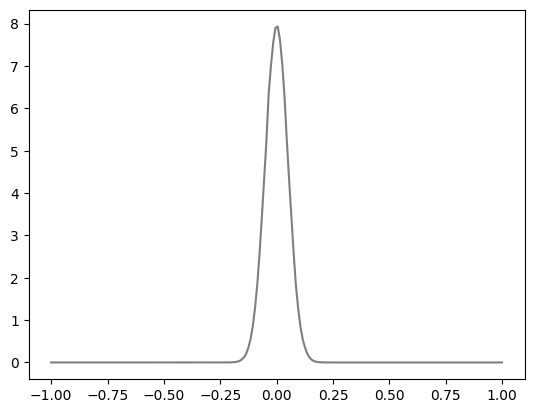

In [34]:

plot_data(error_samples_nr.reshape(-1,1), color="black", alpha=0.5)


**RC-NF rolling predicitions**

In [36]:


y_pred_error_nr = predictionError_NR(trajectory_all, trajectory_N, last_res_for_test, outSize, inSize, trainLen+errorLen, testLen, Wout, W, Win, a, error_samples_nr)



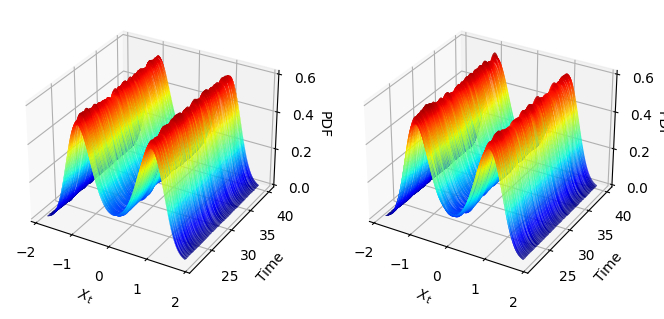

In [38]:
#nr 3D pdf figure
import matplotlib as mpl
import scipy as sp

# datamin = np.min(trajectory_all[:, trainLen+errorLen+1: trainLen+errorLen+1+minLen])
datamin = np.min((trajectory_all[:, trainLen+errorLen+1: trainLen+errorLen+1+minLen], y_pred_error_nr[:, :minLen]))
# datamax = np.max(trajectory_all[:, trainLen+errorLen+1: trainLen+errorLen+1+minLen])
datamax = np.max((trajectory_all[:, trainLen+errorLen+1: trainLen+errorLen+1+minLen], y_pred_error_nr[:, :minLen]))

x_axis = np.linspace(datamin, datamax, 200)
y_axis = np.arange(trainLen+errorLen+1, trainLen+errorLen+1+minLen)*dt
X_axis, Y_axis = np.meshgrid(x_axis, y_axis)
data_Z = np.zeros((200, minLen))
predictionZ = np.zeros((200, minLen))
for i in range(minLen):
    kde_data = sp.stats.gaussian_kde(trajectory_all[:, trainLen+errorLen+1+i])
    kde_prediction = sp.stats.gaussian_kde(y_pred_error_nr[:, i])
    data_Z[:,i] = kde_data(x_axis).reshape(-1,)
    predictionZ[:,i] = kde_prediction(x_axis).reshape(-1,)
# zmax = np.max(data_Z)
zmax = np.max((data_Z, predictionZ))

fig = plt.figure(figsize=(8,4))
norm = mpl.colors.Normalize(vmin=0,vmax=zmax+0.01)
ax1 = fig.add_subplot(121, projection='3d')   
ax1.plot_surface(X_axis,Y_axis, data_Z.T, rstride=1,cstride=1,cmap=plt.cm.jet,norm=norm)
ax1.set_xlabel('$X_t$')
ax1.set_ylabel('Time', rotation = 50)
ax1.set_zlabel('PDF', rotation=270, labelpad=0.)
ax1.set_zlim(0, zmax+0.01)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_axis,Y_axis, predictionZ.T, rstride=1,cstride=1,cmap=plt.cm.jet, norm=norm)
ax2.set_xlabel('$X_t$')
ax2.set_ylabel('Time', rotation = 50)
ax2.set_zlabel('PDF', rotation =270, labelpad=0.)
ax2.set_zlim(0, zmax+0.01)
fig.savefig('./image/DW/DW3Dpdf.jpg',dpi=500,format='jpg')


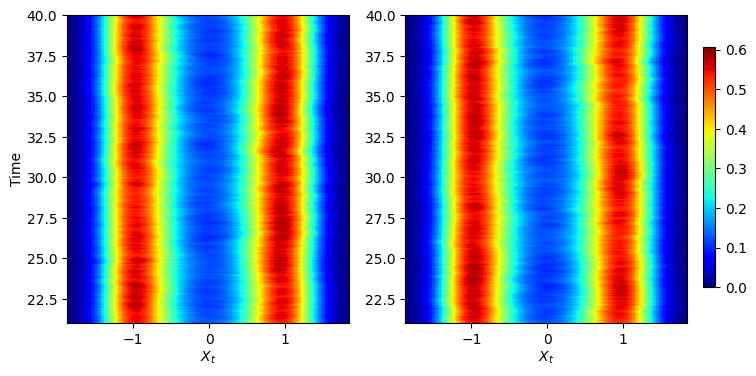

In [39]:
fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(wspace=0.2)
norm = mpl.colors.Normalize(vmin=0,vmax=zmax+0.01)
ax1 = fig.add_subplot(121)   
ax1.pcolormesh(X_axis,Y_axis, data_Z.T,cmap=plt.cm.jet,norm=norm)
ax1.set_xlabel('$X_t$', labelpad = 2)
ax1.set_ylabel('Time', labelpad =2)

ax2 = fig.add_subplot(122)
im=ax2.pcolormesh(X_axis,Y_axis, predictionZ.T,cmap=plt.cm.jet, norm=norm)
ax2.set_xlabel('$X_t$', labelpad = 2)
# ax2.set_ylabel('Time',labelpad = -2)

position = fig.add_axes([0.92, 0.2, 0.015,0.6])
fig.colorbar(im, cax= position)
# fig.savefig('./image/DW/DWpdfhot.jpg',dpi=500,format='jpg')

In [57]:
calculate_time_nr = np.array([100, 500, 1000, 1500, 1900])

In [58]:
### calculate wasserstain distance, KL divergence in prediction (100,500,1000,1500,1900)
##y_error_pred_nr (100,2000), y_error_pred_r (100, 1900)


x_was_nr = torch.tensor(y_pred_error_nr[:,calculate_time_nr - 1].T, dtype=torch.float).unsqueeze(-1)
y_was_nr = torch.tensor(trajectory_all[:, calculate_time_nr + trainLen + errorLen].T, dtype=torch.float).unsqueeze(-1)

sinkhorn = SinkhornDistance(eps=0.01, max_iter=100, reduction=None)
dist_was_nr, P, C = sinkhorn(x_was_nr, y_was_nr)
print("Sinkhorn distance:", dist_was_nr.cpu().numpy())

x_was_all_nr = torch.tensor(y_pred_error_nr[:, :minLen].T, dtype=torch.float).unsqueeze(-1)
y_was_all_nr = torch.tensor(trajectory_all[:, trainLen + errorLen + 1:trainLen + errorLen + 1+minLen].T, dtype=torch.float).unsqueeze(-1)

sinkhorn = SinkhornDistance(eps=0.01, max_iter=100, reduction=None)
dist_was_all_nr, P, C = sinkhorn(x_was_all_nr, y_was_all_nr)
print("Sinkhorn distance:", dist_was_all_nr.cpu().numpy())

# ##If the memory is burst. non-rolling
# was_step = 100
# x_was_list_nr = [y_pred_error_nr[:, :-1][:,i:i+was_step] for i in range(0,y_pred_error_nr[:, :minLen].shape[1],was_step)]
# y_was_list_nr = [trajectory_all[:, trainLen + errorLen + 1:][:,i:i+was_step] for i in range(0,trajectory_all[:, trainLen + errorLen + 1:trainLen + errorLen + 1+minLen].shape[1],was_step)]

# dist_was_all_j_nr = torch.empty(0)
# for j in range(len(y_was_list_nr)):
#     x_was_j_nr = torch.tensor(x_was_list_nr[j].T, dtype=torch.float).unsqueeze(-1)
#     y_was_j_nr = torch.tensor(y_was_list_nr[j].T, dtype=torch.float).unsqueeze(-1)
#     sinkhorn = SinkhornDistance(eps=0.01, max_iter=100, reduction=None)
#     dist_was_j_nr, P, C = sinkhorn(x_was_j_nr, y_was_j_nr)
#     dist_was_all_j_nr = torch.cat((dist_was_all_j_nr, dist_was_j_nr), 0)
    
# print("Sinkhorn distance:", dist_was_all_j_nr.cpu().numpy())

Sinkhorn distance: [0.00533591 0.00546394 0.00543897 0.00516796 0.00517445]
Sinkhorn distance: [0.00497372 0.00500047 0.00505004 ... 0.00514528 0.0051493  0.00517445]


In [59]:
dist_was_all_nr[calculate_time_nr-1]

tensor([0.0053, 0.0055, 0.0054, 0.0052, 0.0052])

In [62]:

print("Sinkhorn distance (non-rolling mean):", dist_was_all_nr[:minLen].cpu().numpy().mean())#,"\n"


Sinkhorn distance (non-rolling mean): 0.005417909


Text(0, 0.5, 'PDF')

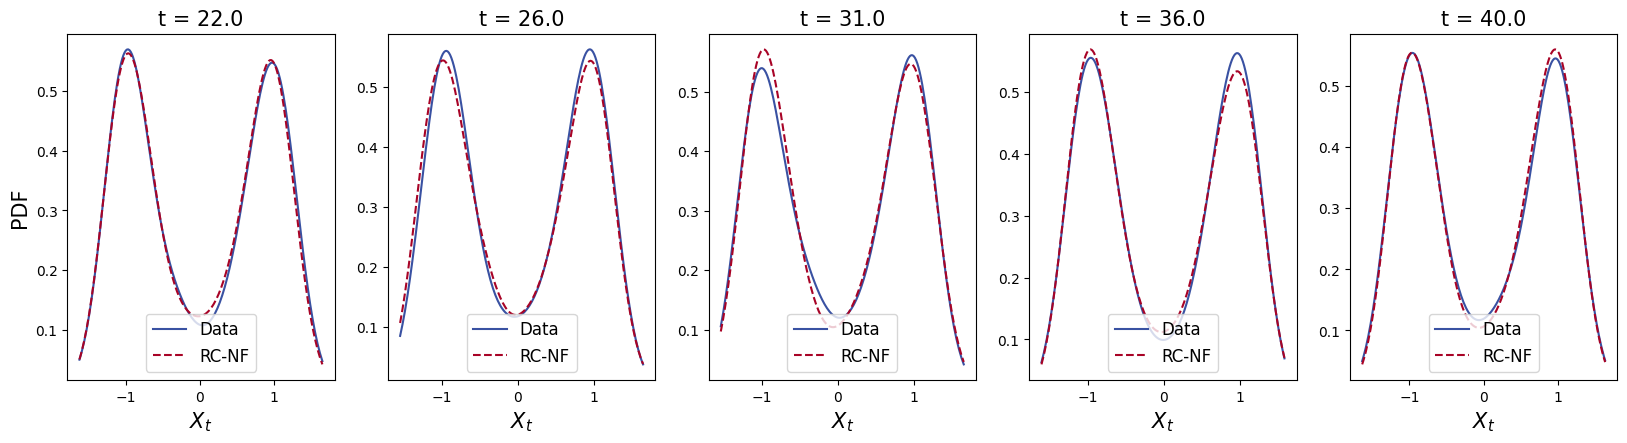

In [64]:
##non-rolling pdf at(100,500,1000,1500,1899)
fig,ax=plt.subplots(1,calculate_time_nr.shape[0],figsize=(20, 4.5))
for i in range(calculate_time_nr.shape[0]):  
    y_t = trajectory_all[:, trainLen + errorLen + calculate_time_nr[i]]
    y_p = y_pred_error_nr[:, calculate_time_nr[i]-1]
    kde_t = sp.stats.gaussian_kde(y_t)
    kde_p = sp.stats.gaussian_kde(y_p)
    x_axis = np.linspace(np.min((y_t,y_p)), np.max((y_t,y_p)), 200)
    ax[i].plot(x_axis, kde_t(x_axis), label="Data", color = '#3951A2',linestyle = '-')
    ax[i].plot(x_axis, kde_p(x_axis), label="RC-NF", color = '#A80326', linestyle = '--')
    ax[i].legend(fontsize = 'large', loc = 'lower center')
    ax[i].set_title('t = {}'.format((calculate_time_nr[i]+trainLen+errorLen)*dt),fontsize=15)
#     ax[i].tick_params(labelsize=8)
    ax[i].set_xlabel('$X_t$',fontsize=15)
    
ax[0].set_ylabel('PDF',fontsize=15)
# fig.text(0.5, 0.02, '$X_t$s\' position', va='center', ha='center', fontsize='large')
# fig.savefig('./image/DW/pdfnrDW.jpg',dpi=500,format='jpg')

**KL divergence**

In [67]:
try: 
    torch.set_default_tensor_type('torch.FloatTensor')
except:
    pass

In [68]:
def KL(y_t, y_p, bins, low, high):
    y_t = y_t.reshape(-1, )
    y_p = y_p.reshape(-1, )
    yt_hist, bins = np.histogram(y_t, bins = bins,range = (low,high),density = True)
    yp_hist, bins = np.histogram(y_p, bins = bins,range = (low,high),density = True)
#     print(yt_hist,yp_hist)
    D = scipy.stats.entropy(yt_hist, yp_hist)
    
    return D
    
def torch_KL(y_t, y_p, bins):
    y_t = torch.tensor(y_t.reshape(-1, ))
    y_p = torch.tensor(y_p.reshape(-1, ))
    low = float(torch.min(y_t.min(), y_p.min()).cpu().numpy())
    high = float(torch.max(y_t.max(), y_p.max()).cpu().numpy())

    yt_hist, tbins = torch.histogram(y_t, bins = bins,range = (low,high),density = True)
    yp_hist, pbins = torch.histogram(y_p, bins = bins,range = (low,high),density = True)
    
    yt_hist_log = torch.log(yt_hist + 1e-8)
    kl_loss = nn.KLDivLoss() 
#     print(yt_hist,yp_hist)
    D = kl_loss(yt_hist_log, yp_hist)
    
    return D

In [69]:
KL_nr = []
KL_r=[]
KL_tr=[]

for t in range(np.min((y_pred_error_nr.shape[1], trajectory_all[:, trainLen+errorLen+1:].shape[1]))):
    y_t = y_pred_error_nr[:, t]
    y_p = trajectory_all[:, trainLen+errorLen+1+t]
    
    kl = torch_KL(y_t = y_t, y_p = y_p, bins = 20)
    KL_nr.append(kl)
KL_nr = np.array(KL_nr)


/home/user/anaconda3/envs/fc/lib/python3.8/site-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


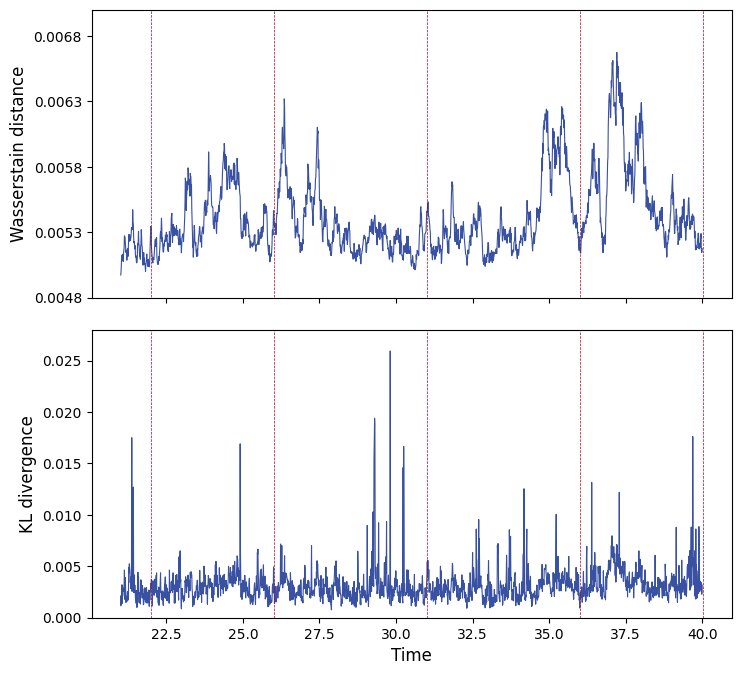

In [70]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.36],
                   xticklabels=[], ylim=(0.0048, 0.007))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.36],
                   ylim=(0.000, 0.028))
ax1.plot(np.arange(trainLen+errorLen+1,trainLen+errorLen+minLen+1)*dt, dist_was_all_nr[:minLen].cpu(), color = '#3951A2', label = "Wasserstain distance",linewidth = .8)
ax2.plot(np.arange(trainLen+errorLen+1,trainLen+errorLen+minLen+1)*dt, KL_nr[:minLen], color = '#3951A2', label = "KL divergence",linewidth = 0.8)
# ax1.legend(loc = 'upper left')
# ax2.legend(loc = 'upper left')
ax1.vlines((trainLen+errorLen+calculate_time_nr+1)*dt, 0, 0.5, color= '#A80326', linestyles='dashed', linewidth = .5)
ax2.vlines((trainLen+errorLen+calculate_time_r+1)*dt, 0, 0.5, color= '#A80326', linestyles='dashed', linewidth = .5)
# ax3 = fig.add_axes([0.1, 0.1, 0.8, 0.3],
#                    ylim=(0.005, 1.5))
# ax3.plot(np.arange(trainLen+errorLen+1,trainLen+errorLen+minLen+1)*dt, dist_was_all_tr.cpu(), label = "Wasserstain distance (Rolling (TNF))",linewidth = 0.8)
# ax3.legend(loc = 'upper left')
# ax3.vlines((trainLen+errorLen+calculate_time_tr+1)*dt, 0, 0.035, color= '#A80326', linestyles='dashed', linewidth = .5)
ax2.set_xlabel('Time',fontsize=12)
ax1.set_ylabel("Wasserstain distance", fontsize=12)
ax2.set_ylabel( "KL divergence", fontsize=12)
ax1.set_yticks(np.arange(0.0048,0.007,0.0005))
# ax2.set_yticks(np.arange(0.,0.016,0.003))
# fig.text(0.01, 0.5, 'Wasserstain Distance', va='center', rotation='vertical')
# fig.savefig('./image/DW/DWwasserstain.jpg',dpi=500,format='jpg')

In [72]:
print("KL divergence at calculate time (non-rolling):", KL_nr[calculate_time_nr-1])
print("KL divergence (non-rolling mean):", KL_nr[:minLen].mean())

KL divergence at calculate time (non-rolling): [0.00291227 0.00493915 0.00355676 0.00093873 0.00317163]
KL divergence (non-rolling mean): 0.0031878843241032297


**generate trajectories and transition rate**

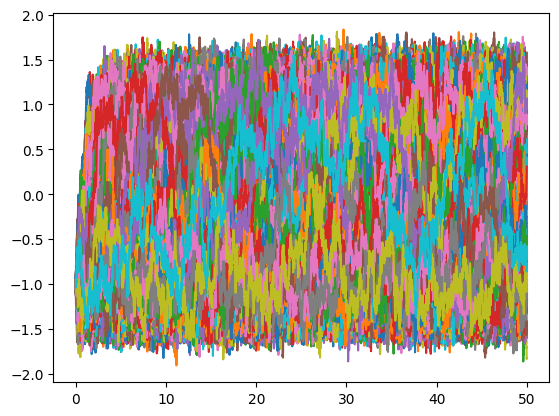

In [73]:
#calculation of transition tate A = (-\infty,0] ,B = (0, \infty) Cab


orbit_N = 2000#number of trajectories
orbit_len = 5000 #length of each trajectory

orbit_all = np.zeros((orbit_N, orbit_len))

y0 = -1.
dt = 0.01

def f(x, t):
    return x - x**3#0.15 * (1.0 - x) 

def g(x, t):
    return .5+ 0 * x

t = np.arange(0, orbit_len) * dt 

for i in range(orbit_N):
    result = sdeint.itoEuler(f, g, y0, t.reshape(-1,), generator = np.random.default_rng(i))
    orbit_all[i] = result.reshape(-1,)
plt.plot(t, orbit_all.T[:,:]) 
# trajectory_all[0] = result.reshape(-1,)
# plt.xlim([-0.1,2.5])
t = t.reshape(-1,1)

In [74]:
from scipy.optimize import leastsq

split = 0

def TransitionRateAB(data, time_len, dt, s):  ##data:$N \times T%; s = split
    cab_ca =[] 
    for i in range(time_len):
        h_a = len(data[:,0][np.where(data[:,0]<=s)])
        h_ab = len(data[:,i][np.where(data[:,i]>s)])
        c_abt = h_ab/h_a
        cab_ca.append(c_abt)
    cab_ca = np.array(cab_ca)
    
    t = np.arange(time_len)*dt
    def f(p):
        k, b = p
        return(cab_ca-(k*t+b))   
    fun = leastsq(f, [1,0])
    kab, b = fun[0]
    print("kab =",kab,"b =",b)
    
    return cab_ca, kab, b




In [75]:
torch.manual_seed(10)

x_ = torch.Tensor(error_train_nr.reshape(-1,1))
error_data__ = model_nr.sample(orbit_N * (orbit_len-initLen)).data.numpy().reshape(-1,)
error_data_ = error_data__ * torch.std(x_[:,0]).numpy() + torch.mean(x_[:,0]).numpy()
error_data = error_data_.reshape(orbit_N, (orbit_len-initLen))

orbit_init = orbit_all[:,:initLen]

yyy = universality(ESN_par, orbit_init, Win, W, Wout, error_data)



kab = 0.013484943878114719 b = 0.03965059983014975
kab = 0.013707486790029488 b = 0.04673956880264278


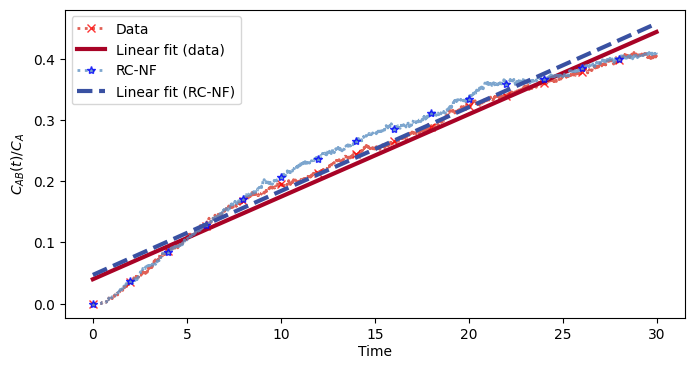

In [82]:
data_cab, data_kab, data_b = TransitionRateAB(orbit_all[:,:3000], orbit_len-2000, dt, split)
ypred_cab, ypred_kab, ypred_b = TransitionRateAB(np.concatenate((orbit_all[:,:initLen],yyy),axis=1)[:,:3000], orbit_len-2000, dt, split)

plt.figure(figsize=(8,4))
plt.plot(np.arange(orbit_len-2000)*dt, data_cab, alpha=0.8, label = 'Data', color='#DA382A', markeredgecolor='red',marker = "x", linewidth = 2, linestyle=':',markevery = 200)
plt.plot(np.arange(orbit_len-2000)*dt, np.arange(orbit_len-2000)*dt*data_kab+data_b, linewidth = 3, label = 'Linear fit (data)', color='#A80326')
plt.plot(np.arange(orbit_len-2000)*dt, ypred_cab, alpha=0.8, label = 'RC-NF', color='#5C90C2', marker = '*', markeredgecolor='blue',linewidth = 2, linestyle=':',markevery = 200)
plt.plot(np.arange(orbit_len-2000)*dt, np.arange(orbit_len-2000)*dt*ypred_kab+ypred_b, linewidth = 3, linestyle='--', label = 'Linear fit (RC-NF)', color='#3951A2')
plt.ylabel('$C_{AB}(t)/C_A$')
plt.xlabel('Time', labelpad=2)
plt.legend()
# plt.savefig('./image/DW/DWCab.jpg',dpi=500,format='jpg')

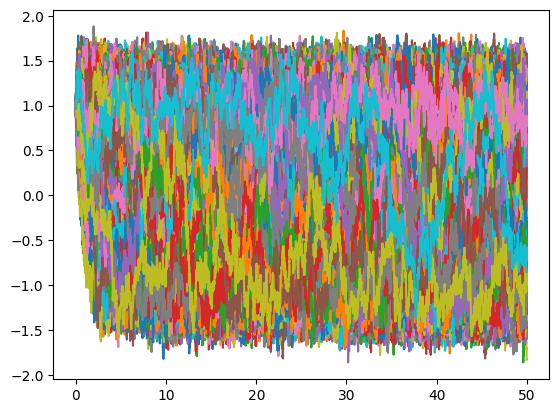

In [77]:
#calculation of transition tate A = (-\infty,0] ,B = (0, \infty) Cba


orbit_N = 2000#number of trajectories
orbit_len = 5000 #length of each trajectory

orbit_all2 = np.zeros((orbit_N, orbit_len))

y0 = 1.

t = np.arange(0, orbit_len) * dt 

for i in range(orbit_N):
    result = sdeint.itoEuler(f, g, y0, t.reshape(-1,), generator = np.random.default_rng(i))
    orbit_all2[i] = result.reshape(-1,)
plt.plot(t, orbit_all2.T[:,:]) 
# trajectory_all[0] = result.reshape(-1,)
# plt.xlim([-0.1,2.5])
t = t.reshape(-1,1)

In [78]:
def TransitionRateBA(data, time_len, dt, s):  ##data:$N \times T%; s = split
    cab_ca =[] 
    for i in range(time_len):
        h_a = len(data[:,0][np.where(data[:,0]>s)])
        h_ab = len(data[:,i][np.where(data[:,i]<=s)])
        c_abt = h_ab/h_a
        cab_ca.append(c_abt)
    cab_ca = np.array(cab_ca)
    
    t = np.arange(time_len)*dt
    def f(p):
        k, b = p
        return(cab_ca-(k*t+b))   
    fun = leastsq(f, [1,0])
    kab, b = fun[0]
    print("kab =",kab,"b =",b)
    
    return cab_ca, kab, b

In [79]:
torch.manual_seed(10)
x_ = torch.Tensor(error_train_nr.reshape(-1,1))
error_data__ = model_nr.sample(orbit_N * (orbit_len-initLen)).data.numpy().reshape(-1,)
error_data_ = error_data__ * torch.std(x_[:,0]).numpy() + torch.mean(x_[:,0]).numpy()
error_data = error_data_.reshape(orbit_N, (orbit_len-initLen))

orbit_init = orbit_all2[:,:initLen]

yyyy = universality(ESN_par, orbit_init, Win, W, Wout, error_data)




In [80]:
data_cba, data_kba, data_b2 = TransitionRateBA(orbit_all2[:,:3000], orbit_len-2000, dt, split)
ypred_cba, ypred_kba, ypred_b2 = TransitionRateBA(np.concatenate((orbit_all2[:,:initLen],yyyy),axis=1)[:,:3000], orbit_len-2000, dt, split)



kab = 0.013835671985369835 b = 0.04401876526380646
kab = 0.01365606969653399 b = 0.05254523494763859


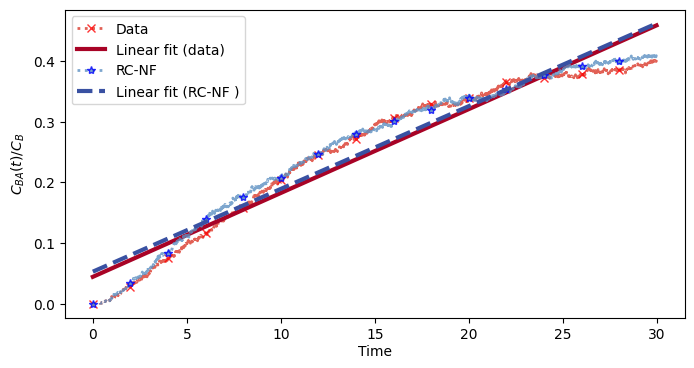

In [81]:
plt.figure(figsize=(8,4))
# plt.scatter(np.arange(orbit_len-2000)*dt, data_cba, s=20, alpha=0.8, label = 'From DW orbits', color='#DA382A', marker = "x", linewidth = 0.8)
plt.plot(np.arange(orbit_len-2000)*dt, data_cba, alpha=0.8, label = 'Data', color='#DA382A', marker = "x", markeredgecolor='red',linewidth = 2, linestyle=':',markevery = 200)
plt.plot(np.arange(orbit_len-2000)*dt, np.arange(orbit_len-2000)*dt*data_kba+data_b2, linewidth = 3, label = 'Linear fit (data)', color='#A80326')
# plt.scatter(np.arange(orbit_len-2000)*dt, ypred_cba, s=20, alpha=0.8, label = 'From RC-NF orbits', color='#5C90C2', marker = '+', linewidth = 0.8)
plt.plot(np.arange(orbit_len-2000)*dt, ypred_cba, alpha=0.8, label = 'RC-NF', color='#5C90C2', marker = '*', markeredgecolor='blue',linewidth = 2, linestyle=':', markevery = 200)
plt.plot(np.arange(orbit_len-2000)*dt, np.arange(orbit_len-2000)*dt*ypred_kba+ypred_b2, linestyle='--', linewidth = 3, label = 'Linear fit (RC-NF )', color='#3951A2')
plt.ylabel('$C_{BA}(t)/C_B$')
plt.xlabel('Time', labelpad=2)
plt.legend()
# plt.savefig('./image/DW/DWCba.jpg',dpi=500,format='jpg')